In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
from sklearn.feature_extraction import DictVectorizer

In [4]:
from sklearn.linear_model import LinearRegression, Lasso

In [5]:
from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')

mlflow.set_experiment('nyc-taxi-experiment')

2024/05/23 09:24:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/23 09:24:34 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716449074588, experiment_id='1', last_update_time=1716449074588, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [9]:
def preprocess_dataframe(df, remove_outliers=True, to_str_features=[]):
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    df_removed_outliers = df
    
    if remove_outliers:
        df_removed_outliers = df[(df.duration >= 1) & (df.duration <= 60)]

    if len(to_str_features) != 0:
        df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)

    return df_removed_outliers

In [10]:
df_jan_23 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [11]:
len(df_jan_23.columns)

19

In [12]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

In [13]:
df_jan_23_removed_outliers = preprocess_dataframe(df_jan_23, to_str_features=categorical)

/var/folders/v1/hmf4py9d5ldgvxxsg3xn50080000gn/T/ipykernel_17188/759168457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)


In [14]:
df_jan_23.duration.std()

42.59435124195458

In [15]:
num_samples_total = len(df_jan_23)
num_samples_total

3066766

In [16]:
df_jan_23_removed_outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [17]:
len(df_jan_23_removed_outliers) / num_samples_total

0.9812202822125979

In [18]:
df_jan_23.duration

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3066766, dtype: float64

In [19]:
df_jan_23_removed_outliers.duration.describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

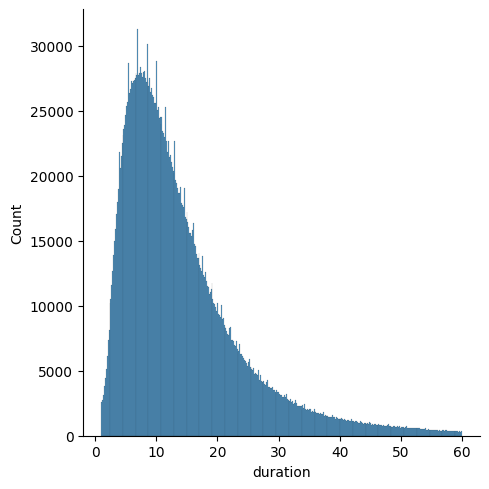

In [20]:
sns.displot(df_jan_23_removed_outliers.duration)

In [21]:
# df_jan_23_removed_outliers[categorical] = df_jan_23_removed_outliers[categorical].astype(str)

In [22]:
df_jan_23_removed_outliers.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [23]:
df_jan_23_removed_outliers[categorical].iloc[0]

PULocationID    161
DOLocationID    141
Name: 0, dtype: object

In [24]:
def fit_features_transform(df, features_names):
    dicts = df[features_names].to_dict(orient='records')
    dv = DictVectorizer()
    dv.fit(dicts)

    return dv

In [25]:
def get_features_target(df, features_names, target_name, features_transform):
    dicts = df[features_names].to_dict(orient='records')
    X = features_transform.transform(dicts)

    y = df[target_name]

    return X, y

In [26]:
# train_dicts = df_jan_23_removed_outliers[categorical + numerical].to_dict(orient='records')

In [27]:
feature_transform = fit_features_transform(df_jan_23_removed_outliers, categorical + numerical)

In [28]:
len(feature_transform.feature_names_) - 1 # one numeric feature

515

In [29]:
X_train, y_train = get_features_target(df_jan_23_removed_outliers, categorical + numerical, target, feature_transform)

In [30]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [31]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [32]:
predictions_train = regressor.predict(X_train)

In [33]:
(((predictions_train - y_train)**2).sum() / len(y_train))**0.5

7.658813384236691

In [34]:
root_mean_squared_error(y_train, predictions_train)

7.658813384236691

In [35]:
sorted(predictions_train)[len(predictions_train)//2]

11.93122024908848

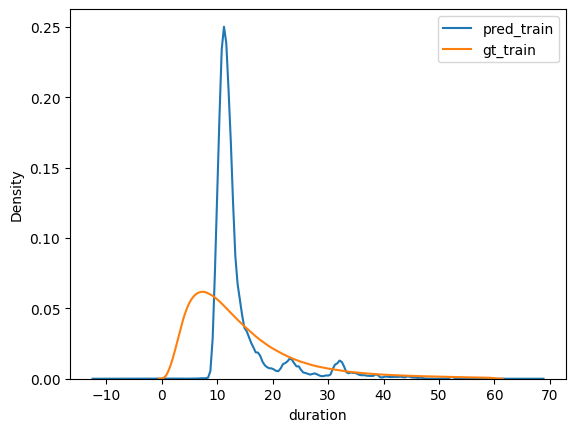

In [36]:
sns.kdeplot(predictions_train, label='pred_train')
sns.kdeplot(y_train, label='gt_train')
plt.legend()

In [37]:
val_df = preprocess_dataframe(pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'), 
                              to_str_features=categorical)

/var/folders/v1/hmf4py9d5ldgvxxsg3xn50080000gn/T/ipykernel_17188/759168457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)


In [38]:
X_val, y_val = get_features_target(val_df, categorical + numerical, target, feature_transform)

In [39]:
pred_val = regressor.predict(X_val)

In [40]:
root_mean_squared_error(y_val, pred_val)

7.820203893965551

In [41]:
pred_val

array([11.37240142, 50.84875858, 15.10540886, ..., 13.53928047,
       10.99123492, 13.18702635])

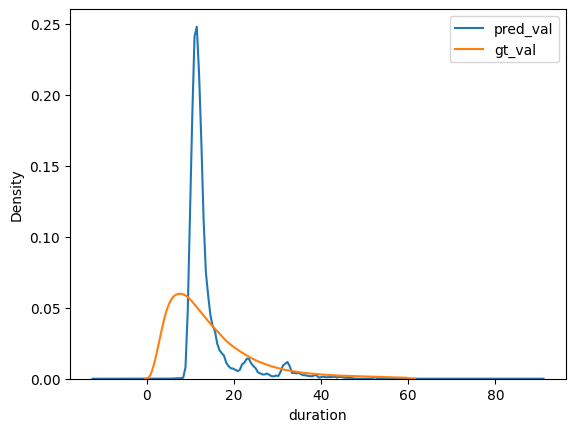

In [42]:
sns.kdeplot(pred_val, label='pred_val')
sns.kdeplot(y_val, label='gt_val')
plt.legend()

In [43]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'aleksandr')
    mlflow.log_param('train-dataset-url', 
                     'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

    mlflow.log_param('val-dataset-url', 
                     'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lasso_reg = Lasso(alpha)

    lasso_reg.fit(X_train, y_train)

    pred_val = lasso_reg.predict(X_val)

    rmse = root_mean_squared_error(y_val, pred_val)
    mlflow.log_metric('rmse', rmse)

In [44]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from functools import partial

In [45]:

def objective(params, train_dataset, val_dataset):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train_dataset,
            num_boost_round=1000,
            evals=[(val_dataset, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(val_dataset)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [46]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [47]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=partial(objective, train_dataset=train, val_dataset=valid),
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.50473                           
[1]	validation-rmse:5.25074                           
[2]	validation-rmse:4.85404                           
[3]	validation-rmse:4.72689                           
[4]	validation-rmse:4.68343                           
[5]	validation-rmse:4.66424                           
[6]	validation-rmse:4.65052                           
[7]	validation-rmse:4.64472                           
[8]	validation-rmse:4.64050                           
[9]	validation-rmse:4.63824                           
[10]	validation-rmse:4.63486                          
[11]	validation-rmse:4.62799                          
[12]	validation-rmse:4.62617                          
[13]	validation-rmse:4.62108                          
[14]	validation-rmse:4.62002                          
[15]	validation-rmse:4.61918                          
[16]	validation-rmse:4.61773                          
[17]	validation-rmse:4.61071                          
[18]	valid

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.11527                                                     
[1]	validation-rmse:8.30682                                                     
[2]	validation-rmse:7.63074                                                     
[3]	validation-rmse:7.06293                                                     
[4]	validation-rmse:6.59528                                                     
[5]	validation-rmse:6.21019                                                     
[6]	validation-rmse:5.89661                                                     
[7]	validation-rmse:5.63630                                                     
[8]	validation-rmse:5.42977                                                     
[9]	validation-rmse:5.26472                                                     
[10]	validation-rmse:5.12849                                                    
[11]	validation-rmse:5.02259                                                    
[12]	validation-rmse:4.93868

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:27:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.13096                                                    
[1]	validation-rmse:8.34103                                                    
[2]	validation-rmse:7.67866                                                    
[3]	validation-rmse:7.12784                                                    
[4]	validation-rmse:6.67244                                                    
[5]	validation-rmse:6.29853                                                    
[6]	validation-rmse:5.99157                                                    
[7]	validation-rmse:5.74392                                                    
[8]	validation-rmse:5.54315                                                    
[9]	validation-rmse:5.38112                                                    
[10]	validation-rmse:5.25087                                                   
[11]	validation-rmse:5.14432                                                   
[12]	validation-rmse:5.06059            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.89613                                                       
[1]	validation-rmse:4.91812                                                       
[2]	validation-rmse:4.69534                                                       
[3]	validation-rmse:4.64623                                                       
[4]	validation-rmse:4.62715                                                       
[5]	validation-rmse:4.61617                                                       
[6]	validation-rmse:4.60790                                                       
[7]	validation-rmse:4.60573                                                       
[8]	validation-rmse:4.60220                                                       
[9]	validation-rmse:4.59978                                                       
[10]	validation-rmse:4.59665                                                      
[11]	validation-rmse:4.59328                                                      
[12]

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:30:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.95415                                                    
[1]	validation-rmse:5.51879                                                    
[2]	validation-rmse:4.94796                                                    
[3]	validation-rmse:4.73627                                                    
[4]	validation-rmse:4.65841                                                    
[5]	validation-rmse:4.62757                                                    
[6]	validation-rmse:4.61426                                                    
[7]	validation-rmse:4.60786                                                    
[8]	validation-rmse:4.60604                                                    
[9]	validation-rmse:4.60531                                                    
[10]	validation-rmse:4.60527                                                   
[11]	validation-rmse:4.60620                                                   
[12]	validation-rmse:4.60612            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.64820                                                    
[1]	validation-rmse:7.55546                                                    
[2]	validation-rmse:6.73696                                                    
[3]	validation-rmse:6.12335                                                    
[4]	validation-rmse:5.68228                                                    
[5]	validation-rmse:5.36594                                                    
[6]	validation-rmse:5.14148                                                    
[7]	validation-rmse:4.98361                                                    
[8]	validation-rmse:4.86778                                                    
[9]	validation-rmse:4.79158                                                    
[10]	validation-rmse:4.73747                                                   
[11]	validation-rmse:4.69772                                                   
[12]	validation-rmse:4.66973            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.49883                                                    
[1]	validation-rmse:4.75044                                                    
[2]	validation-rmse:4.65244                                                    
[3]	validation-rmse:4.63864                                                    
[4]	validation-rmse:4.63591                                                    
[5]	validation-rmse:4.63700                                                    
[6]	validation-rmse:4.63463                                                    
[7]	validation-rmse:4.63407                                                    
[8]	validation-rmse:4.63579                                                    
[9]	validation-rmse:4.63718                                                    
[10]	validation-rmse:4.63541                                                   
[11]	validation-rmse:4.63702                                                   
[12]	validation-rmse:4.64038            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:32:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4.67263                                                    
[1]	validation-rmse:4.65642                                                    
[2]	validation-rmse:4.63403                                                    
[3]	validation-rmse:4.62131                                                    
[4]	validation-rmse:4.61317                                                    
[5]	validation-rmse:4.60818                                                    
[6]	validation-rmse:4.60816                                                    
[7]	validation-rmse:4.60840                                                    
[8]	validation-rmse:4.60758                                                    
[9]	validation-rmse:4.60672                                                    
[10]	validation-rmse:4.60671                                                   
[11]	validation-rmse:4.60663                                                   
[12]	validation-rmse:4.60651            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:33:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.57226                                                    
[1]	validation-rmse:9.11453                                                    
[2]	validation-rmse:8.69445                                                    
[3]	validation-rmse:8.30949                                                    
[4]	validation-rmse:7.95478                                                    
[5]	validation-rmse:7.63191                                                    
[6]	validation-rmse:7.33676                                                    
[7]	validation-rmse:7.06600                                                    
[8]	validation-rmse:6.81862                                                    
[9]	validation-rmse:6.59601                                                    
[10]	validation-rmse:6.39150                                                   
[11]	validation-rmse:6.20859                                                   
[12]	validation-rmse:6.04077            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:35:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98975                                                    
[1]	validation-rmse:8.10428                                                    
[2]	validation-rmse:7.38373                                                    
[3]	validation-rmse:6.80169                                                    
[4]	validation-rmse:6.33305                                                    
[5]	validation-rmse:5.96463                                                    
[6]	validation-rmse:5.67461                                                    
[7]	validation-rmse:5.44772                                                    
[8]	validation-rmse:5.27040                                                    
[9]	validation-rmse:5.13380                                                    
[10]	validation-rmse:5.02367                                                   
[11]	validation-rmse:4.94217                                                   
[12]	validation-rmse:4.87876            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:36:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99154                                                     
[1]	validation-rmse:8.11288                                                     
[2]	validation-rmse:7.40386                                                     
[3]	validation-rmse:6.83534                                                     
[4]	validation-rmse:6.38410                                                     
[5]	validation-rmse:6.02884                                                     
[6]	validation-rmse:5.75179                                                     
[7]	validation-rmse:5.53638                                                     
[8]	validation-rmse:5.36819                                                     
[9]	validation-rmse:5.23848                                                     
[10]	validation-rmse:5.13781                                                    
[11]	validation-rmse:5.05931                                                    
[12]	validation-rmse:4.99881

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:39:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86467                                                       
[1]	validation-rmse:7.90541                                                       
[2]	validation-rmse:7.14400                                                       
[3]	validation-rmse:6.55232                                                       
[4]	validation-rmse:6.09565                                                       
[5]	validation-rmse:5.74728                                                       
[6]	validation-rmse:5.47940                                                       
[7]	validation-rmse:5.28093                                                       
[8]	validation-rmse:5.13294                                                       
[9]	validation-rmse:5.02063                                                       
[10]	validation-rmse:4.93720                                                      
[11]	validation-rmse:4.87370                                                      
[12]

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.12135                                                     
[1]	validation-rmse:6.79508                                                     
[2]	validation-rmse:5.94141                                                     
[3]	validation-rmse:5.39724                                                     
[4]	validation-rmse:5.06867                                                     
[5]	validation-rmse:4.87588                                                     
[6]	validation-rmse:4.76183                                                     
[7]	validation-rmse:4.69188                                                     
[8]	validation-rmse:4.65238                                                     
[9]	validation-rmse:4.62778                                                     
[10]	validation-rmse:4.61305                                                    
[11]	validation-rmse:4.60329                                                    
[12]	validation-rmse:4.59644

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.89410                                                     
[2]	validation-rmse:7.16446                                                     
[3]	validation-rmse:6.61335                                                     
[4]	validation-rmse:6.20321                                                     
[5]	validation-rmse:5.90034                                                     
[6]	validation-rmse:5.67883                                                     
[7]	validation-rmse:5.51783                                                     
[8]	validation-rmse:5.39915                                                     
[9]	validation-rmse:5.31111                                                     
[10]	validation-rmse:5.24707                                                    
[11]	validation-rmse:5.19861                                                    
[12]	validation-rmse:5.16103                                                    
[13]	validation-rmse:5.13299

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80495                                                     
[1]	validation-rmse:7.80336                                                     
[2]	validation-rmse:7.02353                                                     
[3]	validation-rmse:6.41809                                                     
[4]	validation-rmse:5.96031                                                     
[5]	validation-rmse:5.61476                                                     
[6]	validation-rmse:5.35846                                                     
[7]	validation-rmse:5.16516                                                     
[8]	validation-rmse:5.02596                                                     
[9]	validation-rmse:4.92347                                                     
[10]	validation-rmse:4.84621                                                    
[11]	validation-rmse:4.79036                                                    
[12]	validation-rmse:4.74618

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.22361                                                     
[1]	validation-rmse:4.69617                                                     
[2]	validation-rmse:4.64486                                                     
[3]	validation-rmse:4.63828                                                     
[4]	validation-rmse:4.63545                                                     
[5]	validation-rmse:4.63578                                                     
[6]	validation-rmse:4.63499                                                     
[7]	validation-rmse:4.63744                                                     
[8]	validation-rmse:4.63902                                                     
[9]	validation-rmse:4.64097                                                     
[10]	validation-rmse:4.64246                                                    
[11]	validation-rmse:4.64492                                                    
[12]	validation-rmse:4.64562

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:43:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.69765                                                     
[1]	validation-rmse:9.35047                                                     
[2]	validation-rmse:9.02505                                                     
[3]	validation-rmse:8.72057                                                     
[4]	validation-rmse:8.43565                                                     
[5]	validation-rmse:8.16967                                                     
[6]	validation-rmse:7.92132                                                     
[7]	validation-rmse:7.68952                                                     
[8]	validation-rmse:7.47348                                                     
[9]	validation-rmse:7.27253                                                     
[10]	validation-rmse:7.08537                                                    
[11]	validation-rmse:6.91190                                                    
[12]	validation-rmse:6.75094

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.38324                                                     
[1]	validation-rmse:7.18694                                                     
[2]	validation-rmse:6.35960                                                     
[3]	validation-rmse:5.79992                                                     
[4]	validation-rmse:5.42431                                                     
[5]	validation-rmse:5.17960                                                     
[6]	validation-rmse:5.02055                                                     
[7]	validation-rmse:4.91207                                                     
[8]	validation-rmse:4.84190                                                     
[9]	validation-rmse:4.79285                                                     
[10]	validation-rmse:4.76003                                                    
[11]	validation-rmse:4.73664                                                    
[12]	validation-rmse:4.71820

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.62903                                                     
[1]	validation-rmse:9.22060                                                     
[2]	validation-rmse:8.84025                                                     
[3]	validation-rmse:8.48871                                                     
[4]	validation-rmse:8.16108                                                     
[5]	validation-rmse:7.85948                                                     
[6]	validation-rmse:7.57961                                                     
[7]	validation-rmse:7.32205                                                     
[8]	validation-rmse:7.08331                                                     
[9]	validation-rmse:6.86469                                                     
[10]	validation-rmse:6.66392                                                    
[11]	validation-rmse:6.47941                                                    
[12]	validation-rmse:6.31025

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.45376                                                        
[1]	validation-rmse:8.90336                                                        
[2]	validation-rmse:8.41020                                                        
[3]	validation-rmse:7.96918                                                        
[4]	validation-rmse:7.57677                                                        
[5]	validation-rmse:7.22780                                                        
[6]	validation-rmse:6.91886                                                        
[7]	validation-rmse:6.64618                                                        
[8]	validation-rmse:6.40661                                                        
[9]	validation-rmse:6.19441                                                        
[10]	validation-rmse:6.00912                                                       
[11]	validation-rmse:5.84743                                                

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.65248                                                        
[3]	validation-rmse:8.26969                                                        
[4]	validation-rmse:7.92356                                                        
[5]	validation-rmse:7.61337                                                        
[6]	validation-rmse:7.33561                                                        
[7]	validation-rmse:7.08577                                                        
[8]	validation-rmse:6.86364                                                        
[9]	validation-rmse:6.66575                                                        
[10]	validation-rmse:6.49080                                                       
[11]	validation-rmse:6.33482                                                       
[12]	validation-rmse:6.19575                                                       
[13]	validation-rmse:6.07349                                                

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.32062                                                        
[1]	validation-rmse:8.66885                                                        
[2]	validation-rmse:8.10258                                                        
[3]	validation-rmse:7.61324                                                        
[4]	validation-rmse:7.19024                                                        
[5]	validation-rmse:6.82843                                                        
[6]	validation-rmse:6.51830                                                        
[7]	validation-rmse:6.25547                                                        
[8]	validation-rmse:6.03288                                                        
[9]	validation-rmse:5.84369                                                        
[10]	validation-rmse:5.68423                                                       
[11]	validation-rmse:5.55090                                                

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.85769                                                        
[2]	validation-rmse:8.35253                                                        
[3]	validation-rmse:7.90559                                                        
[4]	validation-rmse:7.51231                                                        
[5]	validation-rmse:7.16647                                                        
[6]	validation-rmse:6.86354                                                        
[7]	validation-rmse:6.59938                                                        
[8]	validation-rmse:6.36890                                                        
[9]	validation-rmse:6.16858                                                        
[10]	validation-rmse:5.99514                                                       
[11]	validation-rmse:5.84561                                                       
[12]	validation-rmse:5.71655                                                

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.43650                                                      
[1]	validation-rmse:6.04920                                                      
[2]	validation-rmse:5.36644                                                      
[3]	validation-rmse:5.04300                                                      
[4]	validation-rmse:4.87640                                                      
[5]	validation-rmse:4.79478                                                      
[6]	validation-rmse:4.75292                                                      
[7]	validation-rmse:4.72429                                                      
[8]	validation-rmse:4.70673                                                      
[9]	validation-rmse:4.69373                                                      
[10]	validation-rmse:4.68614                                                     
[11]	validation-rmse:4.67902                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.91487                                                      
[1]	validation-rmse:6.54861                                                      
[2]	validation-rmse:5.72664                                                      
[3]	validation-rmse:5.25132                                                      
[4]	validation-rmse:4.98140                                                      
[5]	validation-rmse:4.82299                                                      
[6]	validation-rmse:4.73751                                                      
[7]	validation-rmse:4.68580                                                      
[8]	validation-rmse:4.65524                                                      
[9]	validation-rmse:4.63688                                                      
[10]	validation-rmse:4.62322                                                     
[11]	validation-rmse:4.61324                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.28061                                                      
[3]	validation-rmse:7.82719                                                      
[4]	validation-rmse:7.43583                                                      
[5]	validation-rmse:7.09681                                                      
[6]	validation-rmse:6.80552                                                      
[7]	validation-rmse:6.55740                                                      
[8]	validation-rmse:6.34457                                                      
[9]	validation-rmse:6.16422                                                      
[10]	validation-rmse:6.00920                                                     
[11]	validation-rmse:5.87853                                                     
[12]	validation-rmse:5.76813                                                     
[13]	validation-rmse:5.67449                                                     
[14]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.46811                                                      
[1]	validation-rmse:8.92357                                                      
[2]	validation-rmse:8.43401                                                      
[3]	validation-rmse:7.99007                                                      
[4]	validation-rmse:7.59401                                                      
[5]	validation-rmse:7.23610                                                      
[6]	validation-rmse:6.91663                                                      
[7]	validation-rmse:6.63384                                                      
[8]	validation-rmse:6.38042                                                      
[9]	validation-rmse:6.15597                                                      
[10]	validation-rmse:5.95909                                                     
[11]	validation-rmse:5.78355                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:08:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.17529                                                      
[1]	validation-rmse:8.41748                                                      
[2]	validation-rmse:7.77857                                                      
[3]	validation-rmse:7.24208                                                      
[4]	validation-rmse:6.79525                                                      
[5]	validation-rmse:6.42586                                                      
[6]	validation-rmse:6.11946                                                      
[7]	validation-rmse:5.86951                                                      
[8]	validation-rmse:5.66513                                                      
[9]	validation-rmse:5.49816                                                      
[10]	validation-rmse:5.36179                                                     
[11]	validation-rmse:5.25225                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.81030                                                      
[1]	validation-rmse:6.43506                                                      
[2]	validation-rmse:5.63687                                                      
[3]	validation-rmse:5.19288                                                      
[4]	validation-rmse:4.94545                                                      
[5]	validation-rmse:4.81252                                                      
[6]	validation-rmse:4.73683                                                      
[7]	validation-rmse:4.69316                                                      
[8]	validation-rmse:4.66719                                                      
[9]	validation-rmse:4.64973                                                      
[10]	validation-rmse:4.63867                                                     
[11]	validation-rmse:4.62962                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.25587                                                      
[1]	validation-rmse:8.55392                                                      
[2]	validation-rmse:7.94759                                                      
[3]	validation-rmse:7.42695                                                      
[4]	validation-rmse:6.98286                                                      
[5]	validation-rmse:6.60229                                                      
[6]	validation-rmse:6.28247                                                      
[7]	validation-rmse:6.01133                                                      
[8]	validation-rmse:5.78615                                                      
[9]	validation-rmse:5.59819                                                      
[10]	validation-rmse:5.43843                                                     
[11]	validation-rmse:5.30838                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:13:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.43827                                                      
[2]	validation-rmse:6.66097                                                      
[3]	validation-rmse:6.12328                                                      
[4]	validation-rmse:5.75879                                                      
[5]	validation-rmse:5.51295                                                      
[6]	validation-rmse:5.34779                                                      
[7]	validation-rmse:5.23635                                                      
[8]	validation-rmse:5.15917                                                      
[9]	validation-rmse:5.10523                                                      
[10]	validation-rmse:5.06718                                                     
[11]	validation-rmse:5.03509                                                     
[12]	validation-rmse:5.01354                                                     
[13]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:14:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.15001                                                      
[1]	validation-rmse:8.37490                                                      
[2]	validation-rmse:7.72544                                                      
[3]	validation-rmse:7.18440                                                      
[4]	validation-rmse:6.73632                                                      
[5]	validation-rmse:6.36938                                                      
[6]	validation-rmse:6.06703                                                      
[7]	validation-rmse:5.82187                                                      
[8]	validation-rmse:5.62299                                                      
[9]	validation-rmse:5.46223                                                      
[10]	validation-rmse:5.33304                                                     
[11]	validation-rmse:5.22958                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:16:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.20684                                                     
[1]	validation-rmse:8.46431                                                     
[2]	validation-rmse:7.83117                                                     
[3]	validation-rmse:7.29215                                                     
[4]	validation-rmse:6.83547                                                     
[5]	validation-rmse:6.44726                                                     
[6]	validation-rmse:6.12581                                                     
[7]	validation-rmse:5.85890                                                     
[8]	validation-rmse:5.63656                                                     
[9]	validation-rmse:5.44926                                                     
[10]	validation-rmse:5.29963                                                    
[11]	validation-rmse:5.17604                                                    
[12]	validation-rmse:5.07573

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:18:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.12999                                                     
[1]	validation-rmse:8.33883                                                     
[2]	validation-rmse:7.67429                                                     
[3]	validation-rmse:7.12195                                                     
[4]	validation-rmse:6.66504                                                     
[5]	validation-rmse:6.28703                                                     
[6]	validation-rmse:5.98042                                                     
[7]	validation-rmse:5.73039                                                     
[8]	validation-rmse:5.52902                                                     
[9]	validation-rmse:5.36563                                                     
[10]	validation-rmse:5.23284                                                    
[11]	validation-rmse:5.12814                                                    
[12]	validation-rmse:5.04296

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:19:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.57121                                                    
[1]	validation-rmse:9.11471                                                    
[2]	validation-rmse:8.69543                                                    
[3]	validation-rmse:8.31143                                                    
[4]	validation-rmse:7.95969                                                    
[5]	validation-rmse:7.63799                                                    
[6]	validation-rmse:7.34264                                                    
[7]	validation-rmse:7.07521                                                    
[8]	validation-rmse:6.83190                                                    
[9]	validation-rmse:6.60894                                                    
[10]	validation-rmse:6.40908                                                   
[11]	validation-rmse:6.22622                                                   
[12]	validation-rmse:6.06321            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.51753                                                     
[1]	validation-rmse:7.35346                                                     
[2]	validation-rmse:6.50762                                                     
[3]	validation-rmse:5.90801                                                     
[4]	validation-rmse:5.48221                                                     
[5]	validation-rmse:5.19525                                                     
[6]	validation-rmse:4.99708                                                     
[7]	validation-rmse:4.86808                                                     
[8]	validation-rmse:4.78028                                                     
[9]	validation-rmse:4.72349                                                     
[10]	validation-rmse:4.68594                                                    
[11]	validation-rmse:4.66101                                                    
[12]	validation-rmse:4.64221

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.57581                                                    
[1]	validation-rmse:5.28215                                                    
[2]	validation-rmse:4.84021                                                    
[3]	validation-rmse:4.70076                                                    
[4]	validation-rmse:4.64652                                                    
[5]	validation-rmse:4.62414                                                    
[6]	validation-rmse:4.61246                                                    
[7]	validation-rmse:4.60334                                                    
[8]	validation-rmse:4.59681                                                    
[9]	validation-rmse:4.59446                                                    
[10]	validation-rmse:4.59073                                                   
[11]	validation-rmse:4.58360                                                   
[12]	validation-rmse:4.57966            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:23:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.31556                                                    
[2]	validation-rmse:8.97663                                                    
[3]	validation-rmse:8.66090                                                    
[4]	validation-rmse:8.36756                                                    
[5]	validation-rmse:8.09456                                                    
[6]	validation-rmse:7.84138                                                    
[7]	validation-rmse:7.60655                                                    
[8]	validation-rmse:7.38885                                                    
[9]	validation-rmse:7.18744                                                    
[10]	validation-rmse:7.00133                                                   
[11]	validation-rmse:6.82913                                                   
[12]	validation-rmse:6.67051                                                   
[13]	validation-rmse:6.52396            

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.02265                                                    
[1]	validation-rmse:8.15301                                                    
[2]	validation-rmse:7.43968                                                    
[3]	validation-rmse:6.85247                                                    
[4]	validation-rmse:6.38107                                                    
[5]	validation-rmse:6.00291                                                    
[6]	validation-rmse:5.69885                                                    
[7]	validation-rmse:5.46139                                                    
[8]	validation-rmse:5.27539                                                    
[9]	validation-rmse:5.12940                                                    
[10]	validation-rmse:5.01602                                                     
[11]	validation-rmse:4.92371                                                     
[12]	validation-rmse:4.85562        

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.10577                                                      
[1]	validation-rmse:5.65043                                                      
[2]	validation-rmse:5.02430                                                      
[3]	validation-rmse:4.76105                                                      
[4]	validation-rmse:4.65830                                                      
[5]	validation-rmse:4.61557                                                      
[6]	validation-rmse:4.59589                                                      
[7]	validation-rmse:4.58640                                                      
[8]	validation-rmse:4.58081                                                      
[9]	validation-rmse:4.57771                                                      
[10]	validation-rmse:4.57533                                                     
[11]	validation-rmse:4.57340                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55030                                                      
[1]	validation-rmse:9.07518                                                      
[2]	validation-rmse:8.63884                                                      
[3]	validation-rmse:8.24183                                                      
[4]	validation-rmse:7.87796                                                      
[5]	validation-rmse:7.54786                                                      
[6]	validation-rmse:7.24550                                                      
[7]	validation-rmse:6.97344                                                      
[8]	validation-rmse:6.72684                                                      
[9]	validation-rmse:6.50141                                                      
[10]	validation-rmse:6.30031                                                     
[11]	validation-rmse:6.11714                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.39166                                                      
[1]	validation-rmse:8.79139                                                      
[2]	validation-rmse:8.25828                                                      
[3]	validation-rmse:7.78591                                                      
[4]	validation-rmse:7.37032                                                      
[5]	validation-rmse:7.00508                                                      
[6]	validation-rmse:6.68312                                                      
[7]	validation-rmse:6.40403                                                      
[8]	validation-rmse:6.16140                                                      
[9]	validation-rmse:5.94913                                                      
[10]	validation-rmse:5.76735                                                     
[11]	validation-rmse:5.61045                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:31:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.14801                                                      
[1]	validation-rmse:6.87634                                                      
[2]	validation-rmse:6.06373                                                      
[3]	validation-rmse:5.55877                                                      
[4]	validation-rmse:5.24895                                                      
[5]	validation-rmse:5.06071                                                      
[6]	validation-rmse:4.94749                                                      
[7]	validation-rmse:4.87342                                                      
[8]	validation-rmse:4.82584                                                      
[9]	validation-rmse:4.78867                                                      
[10]	validation-rmse:4.76774                                                     
[11]	validation-rmse:4.75175                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:32:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.15105                                                      
[1]	validation-rmse:8.37525                                                      
[2]	validation-rmse:7.72038                                                      
[3]	validation-rmse:7.17106                                                      
[4]	validation-rmse:6.71206                                                      
[5]	validation-rmse:6.33498                                                      
[6]	validation-rmse:6.02464                                                      
[7]	validation-rmse:5.76998                                                      
[8]	validation-rmse:5.56258                                                      
[9]	validation-rmse:5.39193                                                      
[10]	validation-rmse:5.25702                                                     
[11]	validation-rmse:5.14554                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:34:02] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.65044                                                      
[1]	validation-rmse:7.55636                                                      
[2]	validation-rmse:6.73580                                                      
[3]	validation-rmse:6.11976                                                      
[4]	validation-rmse:5.67646                                                      
[5]	validation-rmse:5.35315                                                      
[6]	validation-rmse:5.12678                                                      
[7]	validation-rmse:4.96395                                                      
[8]	validation-rmse:4.85320                                                      
[9]	validation-rmse:4.77553                                                      
[10]	validation-rmse:4.71907                                                     
[11]	validation-rmse:4.68042                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:35:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.07440                                                      
[2]	validation-rmse:7.36773                                                      
[3]	validation-rmse:6.80942                                                      
[4]	validation-rmse:6.37426                                                      
[5]	validation-rmse:6.03698                                                      
[6]	validation-rmse:5.77824                                                      
[7]	validation-rmse:5.57940                                                      
[8]	validation-rmse:5.42963                                                      
[9]	validation-rmse:5.31390                                                      
[10]	validation-rmse:5.22511                                                     
[11]	validation-rmse:5.15555                                                     
[12]	validation-rmse:5.10189                                                     
[13]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:37:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.04284                                                      
[1]	validation-rmse:8.19718                                                      
[2]	validation-rmse:7.50672                                                      
[3]	validation-rmse:6.94658                                                      
[4]	validation-rmse:6.49559                                                      
[5]	validation-rmse:6.13564                                                      
[6]	validation-rmse:5.85076                                                      
[7]	validation-rmse:5.62603                                                      
[8]	validation-rmse:5.44873                                                      
[9]	validation-rmse:5.30960                                                      
[10]	validation-rmse:5.20090                                                     
[11]	validation-rmse:5.11531                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:39:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.06241                                                       
[1]	validation-rmse:4.98756                                                       
[2]	validation-rmse:4.71156                                                       
[3]	validation-rmse:4.64937                                                       
[4]	validation-rmse:4.62943                                                       
[5]	validation-rmse:4.61916                                                       
[6]	validation-rmse:4.61341                                                       
[7]	validation-rmse:4.61046                                                       
[8]	validation-rmse:4.60874                                                       
[9]	validation-rmse:4.60743                                                       
[10]	validation-rmse:4.60526                                                      
[11]	validation-rmse:4.60386                                                      
[12]

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56298                                                      
[1]	validation-rmse:6.16149                                                      
[2]	validation-rmse:5.42814                                                      
[3]	validation-rmse:5.04422                                                      
[4]	validation-rmse:4.86077                                                      
[5]	validation-rmse:4.76410                                                      
[6]	validation-rmse:4.71304                                                      
[7]	validation-rmse:4.68370                                                      
[8]	validation-rmse:4.66502                                                      
[9]	validation-rmse:4.65224                                                      
[10]	validation-rmse:4.64310                                                     
[11]	validation-rmse:4.63481                                                     
[12]	validation-

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:40:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.22565                                                      
[1]	validation-rmse:4.92911                                                      
[2]	validation-rmse:4.87268                                                      
[3]	validation-rmse:4.85460                                                      
[4]	validation-rmse:4.82928                                                      
[5]	validation-rmse:4.81632                                                      
[6]	validation-rmse:4.80701                                                      
[7]	validation-rmse:4.78242                                                      
[8]	validation-rmse:4.77363                                                      
[9]	validation-rmse:4.75648                                                      
[10]	validation-rmse:4.74553                                                     
[11]	validation-rmse:4.73647                                                     
[12]	validation-